<a href="https://colab.research.google.com/github/michellecxy015/ml-finacne/blob/main/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import and setting

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [48]:
print(df.head(0))

Empty DataFrame
Columns: [EMP, PE, CAPE, DY, Rho, MOV , IR, RR, Y02, Y10, STP, CF, MG, RV, ED, UN, GDP, M2, CPI, DIL, YSS, NYF, _AU, _DXY, _LCP, _TY, _OIL, _MKT, _VA, _GR, RET]
Index: []

[0 rows x 31 columns]


In [2]:
df = pd.read_excel("market_data.xlsx", sheet_name="US").dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [3]:
df['RET'] = df['_MKT'].pct_change().shift(-1)

feature select

✅ Top features by rolling IC:
        mean_ic
DY    0.207023
YSS   0.110658
MOV   0.072364
_TY   0.058585
M2    0.013391
UN    0.008109
_AU   0.004468
STP   0.003033
_DXY  0.001623
MG   -0.000212


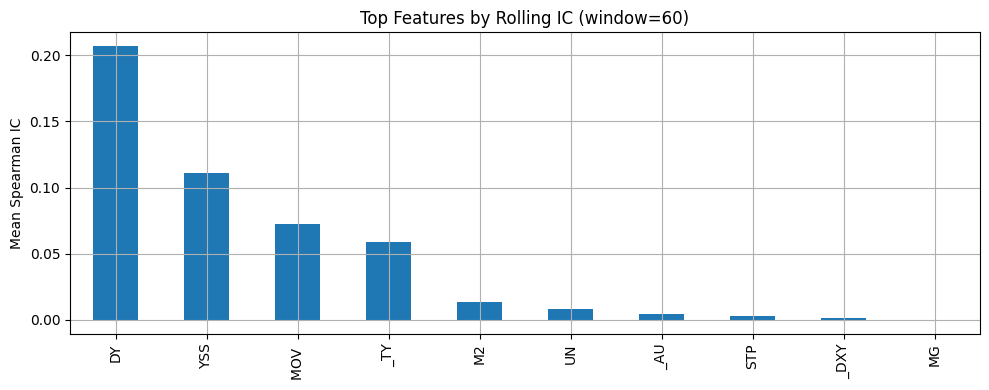

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# === Step 1: 加载数据 ===
df = pd.read_excel("market_data.xlsx", sheet_name="US").dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# === Step 2: 构造目标变量 ===
df['target'] = df['_MKT'].pct_change().shift(-1)
df = df.dropna()

# === Step 3: 修正后的滑窗 IC 函数 ===
def rolling_ic(df, feature, target='target', window=60):
    f = df[feature]
    t = df[target]
    return f.rolling(window).corr(t)

# === Step 4: 遍历特征计算平均 IC ===
feature_cols = [col for col in df.columns if col not in ['_MKT', 'target']]
ic_summary = {}

for feat in feature_cols:
    ic_series = rolling_ic(df, feat, target='target', window=60)
    ic_summary[feat] = ic_series.mean()

# === Step 5: 排序 & 输出前十名特征 ===
ic_df = pd.DataFrame.from_dict(ic_summary, orient='index', columns=["mean_ic"]).dropna()
ic_df = ic_df.sort_values(by="mean_ic", ascending=False)
top_features = ic_df.head(10)
print("✅ Top features by rolling IC:\n", top_features)

# === Step 6: 可视化 ===
plt.figure(figsize=(10, 4))
top_features['mean_ic'].plot(kind='bar')
plt.title("Top Features by Rolling IC (window=60)")
plt.ylabel("Mean Spearman IC")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Select your top features
top_features = ['DY', 'YSS', 'MOV ', '_TY', 'M2', 'UN', '_AU', 'STP', '_DXY', 'MG']
results = []

# -----------------------
# Step 2: Try all 2–4 feature combinations
# -----------------------
for k in [2, 3, 4]:
    for feature_combo in combinations(top_features, k):
        X = df[list(feature_combo)].copy()
        y = df['target'].copy()

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Time-series split (no shuffle)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

        # Build simple DNN model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # Train with early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0, callbacks=[early_stop])

        # Predict
        preds = model.predict(X_scaled).flatten()

        # Evaluate
        ic = spearmanr(preds, y)[0]
        excess_returns = preds * df['_MKT'].shift(-1)
        sharpe = excess_returns.mean() / excess_returns.std() * np.sqrt(252)

        results.append({
            'features': feature_combo,
            'IC': ic,
            'Sharpe': sharpe
        })

# -----------------------
# Step 3: Show Best Results
# -----------------------
result_df = pd.DataFrame(results)
result_df = result_df.sort_values(by='IC', ascending=False).reset_index(drop=True)

print("✅ Top Combinations by Spearman IC:")
print(result_df.head(10))
result_df.to_csv("dnn_combo_results.csv", index=False)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
61/61 ━━━━━━━━━━━━━━━━━━━

evaluation


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def compute_rolling_sharpe(returns, window=12):
    rolling_mean = returns.rolling(window=window).mean()
    rolling_std = returns.rolling(window=window).std()
    return rolling_mean / rolling_std

def evaluate_strategy_with_dnn(data, signal_set, hidden_layers=[32, 16], window=12):
    df = data.dropna().copy()
    df = df[df.columns.intersection(signal_set + ('RET',))].dropna()

    X = df[list(signal_set)]
    y = df['RET']
    dates = df.index

    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 划分训练测试集
    X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(
        X_scaled, y, dates, test_size=0.2, shuffle=False
    )

    # 构建 Keras DNN
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))  # 回归输出

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # 预测
    y_pred = model.predict(X_test).flatten()

    # 指标计算
    ic, _ = spearmanr(y_test, y_pred)
    strategy_returns = y_test * np.sign(y_pred)
    sharpe = strategy_returns.mean() / strategy_returns.std()

    # 绘图：预测 vs 真实
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, y_test, label='True Returns')
    plt.plot(date_test, y_pred, label='Predicted Signal')
    plt.title(f'Prediction vs True | {signal_set}\nIC={ic:.3f}, Sharpe={sharpe:.2f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 策略 vs 标的累计收益
    strategy_cum = strategy_returns.cumsum()
    underlying_cum = y_test.cumsum()

    plt.figure(figsize=(12, 4))
    plt.plot(date_test, strategy_cum, label='Strategy Cumulative PnL')
    plt.plot(date_test, underlying_cum, label='Underlying Cumulative Return')
    plt.title(f'Strategy Backtest | {signal_set}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Rolling Sharpe Ratio
    rolling_sharpe = compute_rolling_sharpe(strategy_returns, window=window)
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, rolling_sharpe)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Rolling Sharpe Ratio | {signal_set}')
    plt.xlabel("Time")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'ic': ic,
        'sharpe': sharpe,
        'rolling_sharpe': rolling_sharpe
    }


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


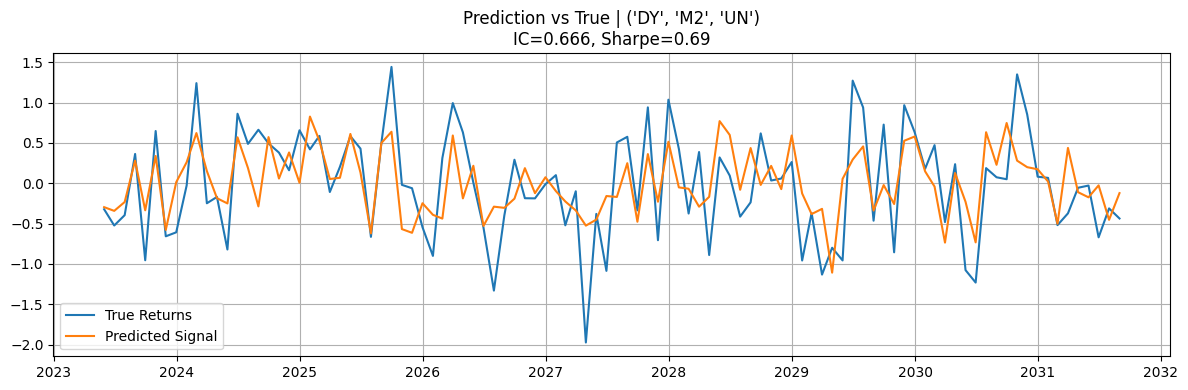

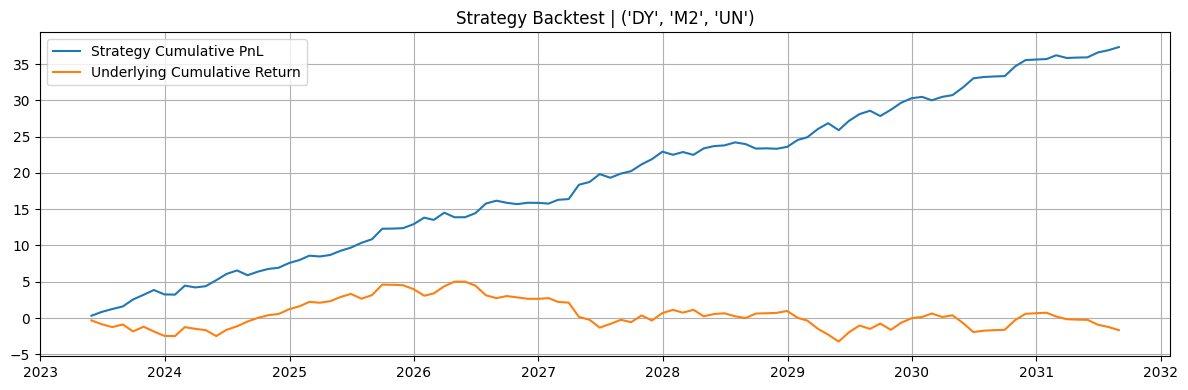

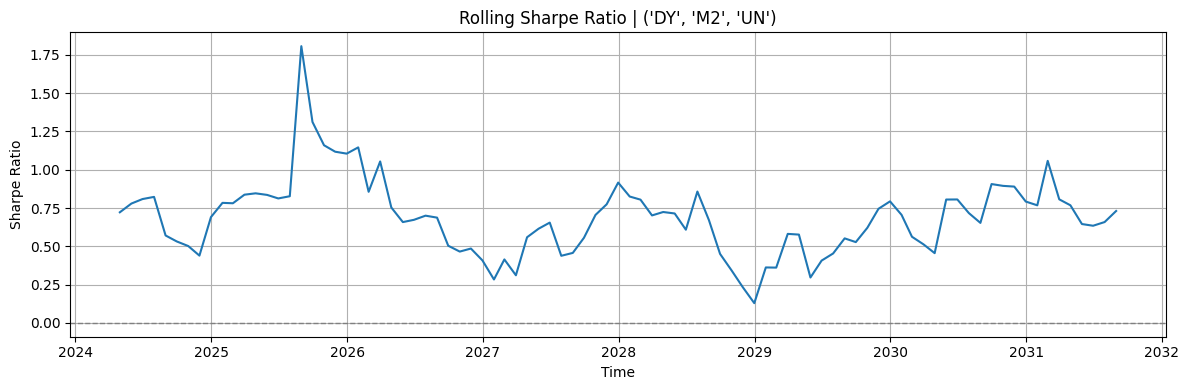

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


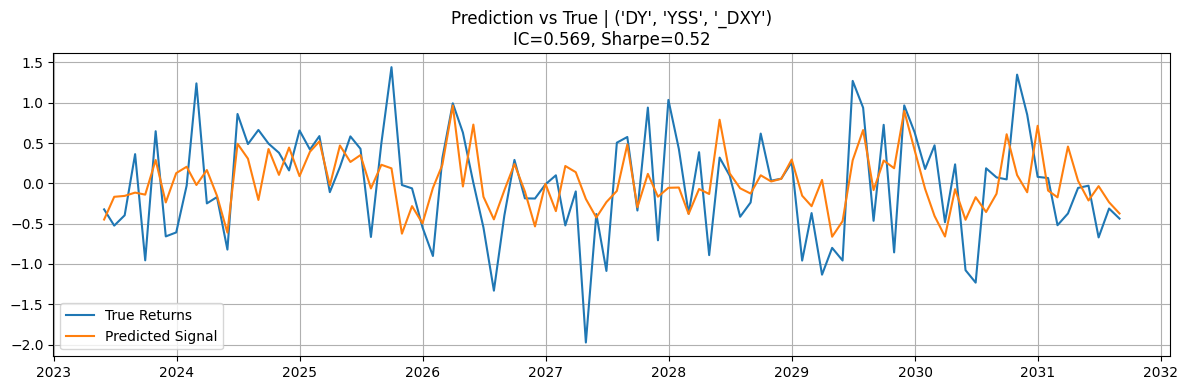

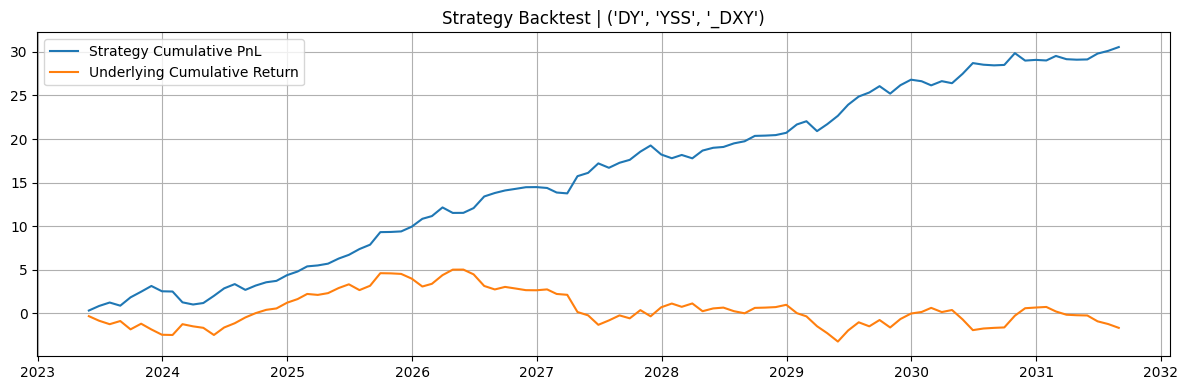

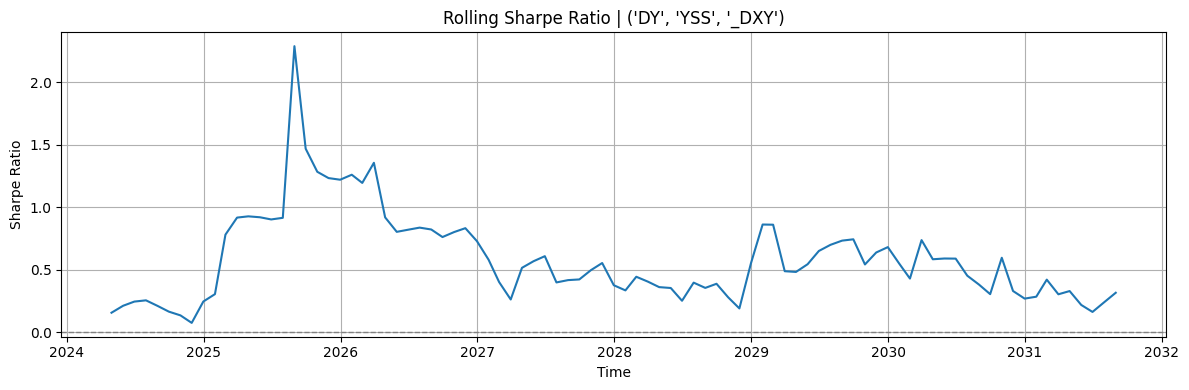

In [15]:
signal_1 = ('DY', 'M2', 'UN')
signal_2 = ('DY', 'YSS', '_DXY')

result_1 = evaluate_strategy_with_dnn(df,signal_1)
result_2 = evaluate_strategy_with_dnn(df, signal_2)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def compute_rolling_sharpe(returns: pd.Series, window: int = 63) -> pd.Series:
    mu = returns.rolling(window).mean()
    sigma = returns.rolling(window).std()
    return mu / sigma

def evaluate_dnn_with_regularization(
    data: pd.DataFrame,
    signal_set: tuple,
    train_frac: float = 0.75,
    hidden_layers=(64, 32),
    epochs: int = 100,
    batch_size: int = 32
) -> dict:
    df = data.dropna().copy()
    df = df[df.columns.intersection(signal_set + ('RET',))].dropna()

    dates = df.index
    split_i = int(len(df) * train_frac)

    X_train = df.iloc[:split_i][list(signal_set)].values
    X_test  = df.iloc[split_i:][list(signal_set)].values
    y_train = df.iloc[:split_i]['RET'].values
    y_test  = df.iloc[split_i:]['RET'].values
    dates_train = df.index[:split_i]
    dates_test  = df.index[split_i:]

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)

    # 构建模型
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer=Adam(0.001), loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs,
              batch_size=batch_size, verbose=0, callbacks=[early_stop])

    pred_train = model.predict(X_train).flatten()
    pred_test  = model.predict(X_test).flatten()

    ic_in  = spearmanr(y_train, pred_train).correlation
    ic_out = spearmanr(y_test,  pred_test).correlation

    strat_ret_in  = y_train * np.sign(pred_train)
    strat_ret_out = y_test  * np.sign(pred_test)

    sr_in  = strat_ret_in.mean()  / strat_ret_in.std()
    sr_out = strat_ret_out.mean() / strat_ret_out.std()

    print(f"{signal_set}  |  IC_in={ic_in:.3f}, SR_in={sr_in:.2f}  "
          f"|  IC_out={ic_out:.3f}, SR_out={sr_out:.2f}")

    cum_bench = np.concatenate([np.cumsum(y_train),  np.cumsum(y_test)])
    cum_strat = np.concatenate([np.cumsum(strat_ret_in), np.cumsum(strat_ret_out)])

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # 左图：累计收益
    axes[0].plot(dates, cum_bench, linestyle='--', color='gray', label='Benchmark')
    axes[0].plot(dates, cum_strat, color='tab:blue', label='Strategy')
    axes[0].axvline(dates[split_i], color='black', linestyle=':', label='Train/Test Split')
    axes[0].set_title('Cumulative Returns (In & Out)')
    axes[0].legend()
    axes[0].grid(True)

    # 右图：Out-of-sample rolling Sharpe
    rolling_sr = compute_rolling_sharpe(pd.Series(strat_ret_out, index=dates_test))
    axes[1].plot(rolling_sr.index, rolling_sr.values, color='tab:red')
    axes[1].axhline(0, linestyle='--', color='gray')
    axes[1].set_title('Out-of-Sample Rolling Sharpe (3M)')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'ic_in': ic_in,
        'sr_in': sr_in,
        'ic_out': ic_out,
        'sr_out': sr_out,
        'rolling_sr_out': rolling_sr
    }

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
('DY', 'M2', 'UN')  |  IC_in=0.017, SR_in=0.09  |  IC_out=-0.000, SR_out=-0.05


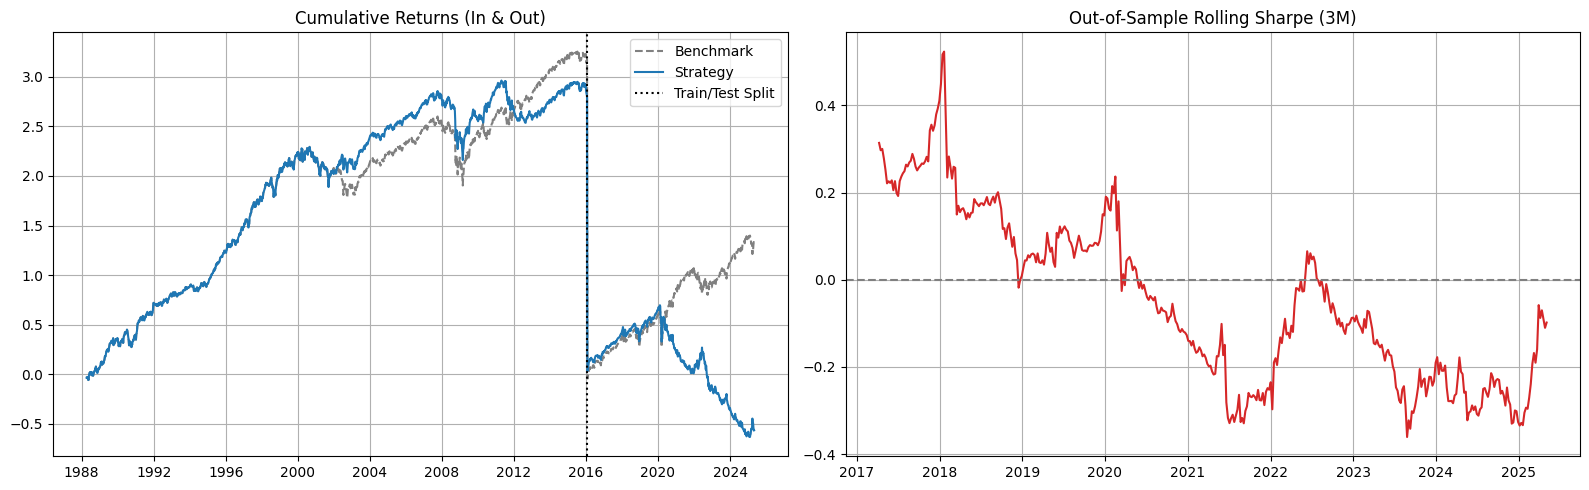

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
('DY', 'YSS', '_DXY')  |  IC_in=-0.037, SR_in=0.10  |  IC_out=-0.064, SR_out=0.11


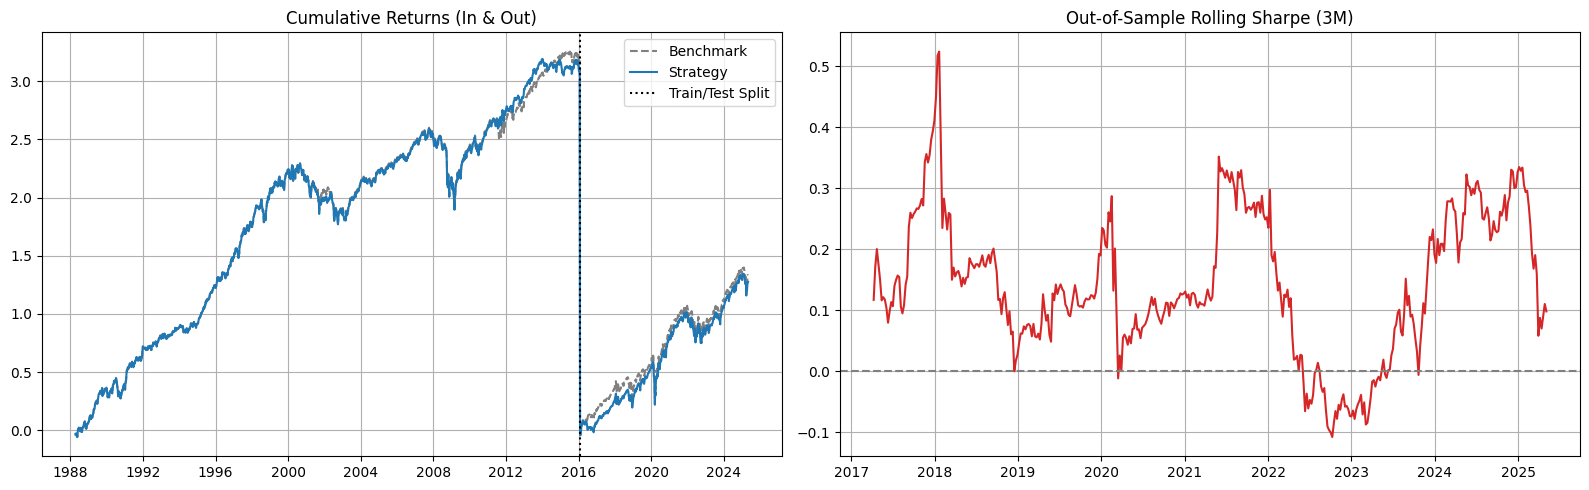

In [14]:
signal_1 = ('DY', 'M2', 'UN')
signal_2 = ('DY', 'YSS', '_DXY')

res1 = evaluate_dnn_with_regularization(df, signal_1)
res2 = evaluate_dnn_with_regularization(df, signal_2)
